# pyharm Examples

This notebook is intended to demonstrate basic use of pyharm.  It is a work in progress, additions or issues welcome
Note this requires pyharm to be installed with `pip install -e .`, unless you move it to the root of this repository.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyharm
import pyharm.plots.plot_dumps as pplt

# Suppress warnings, to avoid math warnings for /0 or sqrt(-)
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The heart of pyharm is the FluidDump object, which acts like a dictionary of different fluid variables, where the members are evaluated "lazily" on demand.
The `load_dump` statement below just opens the file and loads some properties, so it is very cheap -- anything you need will be read or calculated on demand.

The sample file used in this notebook can be downloaded [here](https://uofi.box.com/s/wlrnmi0nkfrsnyhiuv3jdtscfskz25rn)

In [2]:
dump = pyharm.load_dump("SANE_a+0.94_288_0900_MKS.h5")

Once loaded, the file acts like a dictionary of numpy arrays, with the notable exception that `.keys()` and iterations do not work, since you can't actually enumerate all valid "members."  A mostly full list of valid keys is in the [documentation](https://pyharm.readthedocs.io/en/latest/keys.html).

In this case, we ask for the fluid density in zone 11,12,13 (in r, th, phi respectively), then plot the solid-angular distribution of gas pressure at the 30th zone from the center.  Of course, this plot just lays out each value by zone number, without any coordinate information -- for angular plots this is often fine, but we'll see some tools in pyharm for incorporating this information later.

0.0066448356956243515
99.42594947519058
-0.00220352570081804
-0.33161477600854294


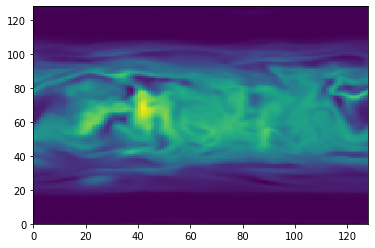

In [3]:
print(dump['rho'][11,12,13])
print(dump['sigma'][11,12,13])
print(dump['FM'][11,12,13])
print(dump['ucon'][1][11,12,13])
plt.pcolormesh(dump['Pg'][100,:,:])

If you don't want to spend the time to calculate a variable over every zone in a dump file, you can take a slice of a dump file and calculate variables over just that slice.

This cell will run much faster than the previous one, but that isn't only because of slicing -- pyharm also *caches* variables it's calculated before, and these caches carry over when a slice is taken.  So, pyharm is not actually recalculating any of the values below, just using the same ones we printed above.

In [4]:
dump_slc = dump[11,12,13]
print(dump_slc['rho'])
print(dump_slc['sigma'])
print(dump_slc['FM'])
print(dump_slc['ucon'][1])

0.0066448356956243515
99.42594947519058
-0.00220352570081804
-0.33161477600854294


Here's an example of calculating the dimensionless event-horizon magnetization, usually denoted $\phi_B$.

Note that when you specify a variable for a reduction like this, you can pass just a string with the name of a variable directly (e.g. 'jsq' for the 4-current density),
or retrieve the variable as above, do some operations on the array, and pass a whole numpy array to the reduction function.

A limited library of operations can be specified in the variable name itself using prefixes, e.g. `log_` for log10, `ln_` for natural log, and `abs_` for absolute value.

If you can pass all the operations you need as a part of the string, instead of doing them yourself, you gain some efficiency: this reduction needs only the 5th row of the array, and if called like this it will only read and perform operations on the necessary slice of the overall file.

In [5]:
0.5 * pyharm.shell_sum(dump, 'abs_B1', at_i=5) / np.sqrt(np.abs(pyharm.shell_sum(dump, 'FM', at_i=5)))

8.701083137775118

Here's the accretion rate plotted vs radius, summed only in the disk, then over the full sphere.  Note this is just for one dump file of a very old simulation, so the rate is not terribly stable.

The function 'pretty' tries to guess the LaTeX name that represents a variable.  It's hit-and-miss of course, but often labels simple plots correctly.

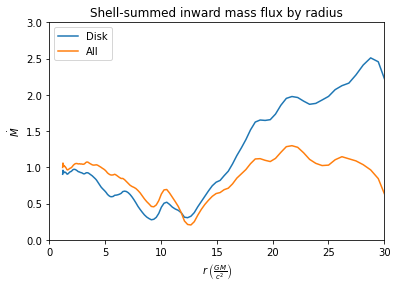

In [6]:
plt.plot(dump['r1d'], -pyharm.shell_sum(dump, 'FM', th_slice=(5*np.pi/12, 7*np.pi/12)), label="Disk")
plt.plot(dump['r1d'], -pyharm.shell_sum(dump, 'FM'), label="All")
plt.xlim(0,30)
plt.ylim(0,3)
plt.xlabel(pyharm.pretty('r'))
plt.ylabel(pyharm.pretty('Mdot'))
plt.title(r"Shell-summed inward mass flux by radius")
plt.legend()

The shell-averaged azimuthal velocity as a function of radius is much more stable:

Note the variable 'u^phi' -- this is the phi component of the 4-velocity in Kerr-Schild coordinates, not Modified Kerr-Schild Coordinates.  That is, pyharm has converted 'ucon' to straight KS ('ucon_base'), and this is the phi component of that converted 4-vector. One can equivalently write dump['ucon_base'][3], as shown.

This convention is a convenient way to get the MHD stress-energy tensor: just ask for 'T^mu_nu' (or use 'TEM' or 'TFl' to get just the E&M or fluid pieces).  The Maxwell tensor F is also supported.

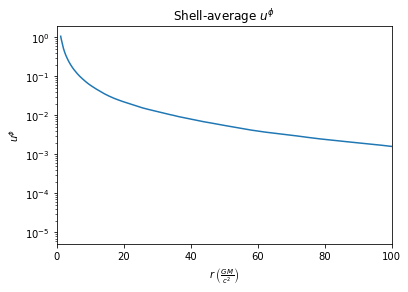

True
0.42796539663122196


In [7]:
plt.plot(dump['r1d'], pyharm.shell_avg(dump, 'u^phi'))
plt.xlim(0,100)
plt.yscale('log')
plt.xlabel(pyharm.pretty('r'))
plt.ylabel(pyharm.pretty('u^phi'))
plt.title(r"Shell-average $u^{\phi}$")
plt.show()

print(np.all(dump['u^phi'] == dump['ucon_base'][3]))

# Total energy, for example
print(-dump[11,11,11]['T^0_0'])

As hinted above, pyharm has some tools for plotting in proper coordinates.  This is done without messy grid files or anything, purely with geometry generated by pyharm using `coordinates.py`.  Flat and Gouraud shading are properly supported using the true cell center and corner locations, and plots will have none of the unsightly gaps characteristic of first attempts plotting simulation output.

You can overlay contours in any variable at a given list of values using `overlay_contours`!

Note that plotting functions require an existing axis object, for flexibility.

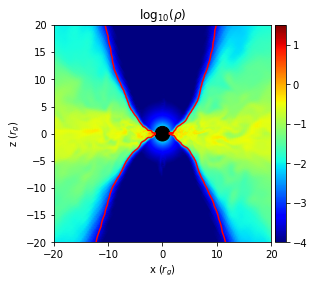

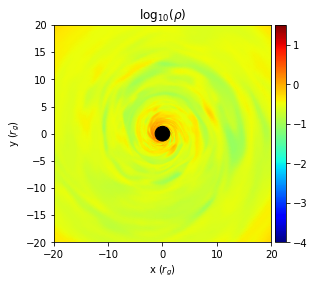

In [8]:
fig, ax = plt.subplots(1,1)
pplt.plot_xz(ax, dump, 'log_rho', vmin=-4, vmax=1.5, window=(-20,20,-20,20))
pplt.overlay_contours(ax, dump, 'sigma', (1.0,), color='r')
fig, ax = plt.subplots(1,1)
pplt.plot_xy(ax, dump, 'log_rho', vmin=-4, vmax=1.5, window=(-20,20,-20,20))

Let's take a closer look at $\sigma$, this time zone by zone -- due to the low resolution here, it really only gets close to 1 for about one zone!

We can also return to that pressure plot we made before, and re-plot in Kerr-Schild $\theta$ and $\phi$ rather than by zone.  Not a drastic change, but the compression of zones near the midplane for accuracy is very apparent when you compare against the zone-by-zone "native" coordinate version.

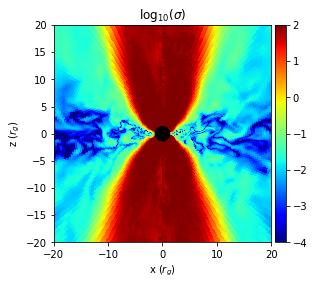

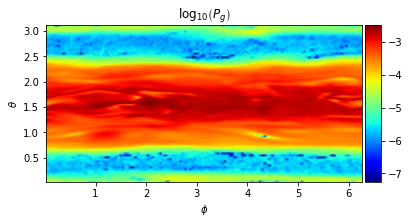

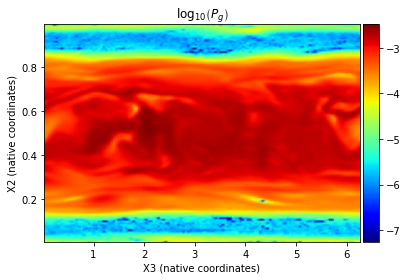

In [9]:
fig, ax = plt.subplots(1,1)
pplt.plot_xz(ax, dump, 'log_sigma', vmin=-4, vmax=2, window=(-20,20,-20,20), shading='flat')

fig, ax = plt.subplots(1,1)
pplt.plot_thphi(ax, dump, 'log_Pg', at_i=100)

fig, ax = plt.subplots(1,1)
pplt.plot_thphi(ax, dump, 'log_Pg', at_i=100, native=True)

As you can see, with a file open you can just start to have fun.

Here's an example: is the polar range $\pi$/3 - 2 $\pi$/3 really representative of the "disk"?  Let's check how much of the accretion falls in that range!

First, we can plot it. 'FM' is the rest-mass flux $\rho u^r$, and since we're looking for just the inward portion, we negate it and take the logarithm.  Then we can calculate the specific portion of accretion within the range, for example at the event horizon.

In this case, the plotting provides good context for the EH numbers, since it shows that even out to 10M, most inward flow is within the $\pi$/3 - 2 $\pi$/3 range.  It also implies that while a smaller range would still capture most accretion at the event horizon, it would not work so well farther out in the disk.

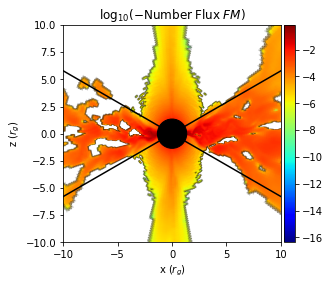

Accreted within disk: 0.9474408427756168
Total accreted: 1.0150056400239504
Percentage: 93.34340671774599


In [10]:
fig, ax = plt.subplots(1,1)
pplt.plot_xz(ax, dump, 'log_neg_FM', window=[-10,10,-10,10])
pplt.overlay_contours(ax, dump, 'th', [np.pi/3, 2*np.pi/3])
plt.show()

in_disk = -pyharm.shell_sum(dump, 'FM', at_i=5, th_slice=(np.pi/3, 2*np.pi/3))
total = -pyharm.shell_sum(dump, 'FM', at_i=5)

print("Accreted within disk:", in_disk)
print("Total accreted:", total)
print("Percentage:",in_disk/total*100)
